# Training and maintaining MNIST predictions

In this notebook we'll be implementing a classic machine learning classification task: MNIST hand written digit
recognition, using a convolution neural network, but with a twist: we'll be implementing the task *in database* using SuperDuperDB.

SuperDuperDB supports MongoDB as a databackend. Correspondingly, we'll import the python MongoDB client `pymongo`
and "wrap" our database to convert it to a SuperDuper `Datalayer`:

In [1]:
import pymongo
import torch
import torchvision

from superduperdb import superduper

db = pymongo.MongoClient().documents

db = superduper(db)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Now that we've connected to SuperDuperDB, let's add some data. MNIST is a good show case for one of the 
key benefits of SuperDuperDB - adding "difficult" data types. This can be done using an `Encoder` 
which is a key wrapper in SuperDuperDB's arsenal. The `Encoder` works closely together with the `Document` 
wrapper. Together they allow Python dictionaries containing non-JSONable/ `bytes` objects, to be insert into
SuperDuperDB:

In [3]:
from superduperdb.encoders.pillow.image import pil_image as i
from superduperdb.core.document import Document as D
from superduperdb.datalayer.mongodb.query import Collection

import random

collection = Collection(name='mnist')

mnist_data = list(torchvision.datasets.MNIST(root='./data', download=True))
data = [D({'img': i(x[0]), 'class': x[1]}) for x in mnist_data]
random.shuffle(data)

db.execute(
    collection.insert_many(data[:-1000], encoders=[i])
)

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x185416c20>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x1812fee90>, G=<networkx.classes.digraph.DiGraph object at 0x16be61dd0>))

Now that we've inserted the images and their classes to the database, let's query some data:

In [4]:
r = db.execute(collection.find_one())
r

Document({'_id': ObjectId('64bb3671117eb460ca78cdcd'), 'img': Encodable(x=<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x18133DF90>, encoder=Encoder(identifier='pil_image', decoder=<Artifact artifact=<function decode_pil_image at 0x18134a840> serializer=dill>, encoder=<Artifact artifact=<function encode_pil_image at 0x1812dfa60> serializer=dill>, shape=None, version=0)), 'class': 7, '_fold': 'valid'})

When we query the data, it's in exactly the format we inserted it. In particular, we can use the `PIL.Image` instances
to inspect the data:

In [5]:
r['img'].x

Now let's create our model. SuperDuperDB supports these frameworks, out-of-the-box:

- `torch`
- `sklearn`
- `transformers`
- `sentence_transformers`
- `openai`
- `langchain`

In this case, we're going to use PyTorch, since it's great for computer vision use-cases.
We can combine `torch` with `torchvision` in SuperDuperDB.

In [6]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(400, 120)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(120, 84)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    
def postprocess(x):
    return int(x.topk(1)[1].item())


def preprocess(x):
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
    )(x)

We've created `postprocess` and `preprocess` functions to handle the communication with the SuperDuperDB
`Datalayer`. In order to create a native SuperDuperDB model, we wrap the model, preprocessing and postprocessing:

In [7]:
model = superduper(LeNet5(10), preprocess=preprocess, postprocess=postprocess)

The model predicts human readable outputs, directly from the `PIL.Image` objects. All 
models in SuperDuperDB are equipped with a `sklearn`-style `.predict` method. This makes 
it easy to know how each AI-framework will operate in combination with the `Datalayer`.

In [8]:
model.predict([r['img'] for r in data[:10]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 466.14it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Now we're ready to "train" or "fit" the model. Trainable models in SuperDuperDB are equipped 
with a `sklearn`-like `.fit` method:

In [9]:
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from superduperdb.core.metric import Metric
from superduperdb.metrics.classification import compute_classification_metrics
from superduperdb.core.dataset import Dataset
from superduperdb.models.torch.wrapper import TorchTrainerConfiguration


job = model.fit(
    X='img',
    y='class',
    db=db,
    select=Collection(name='mnist').find(),
    configuration=TorchTrainerConfiguration(
        identifier='my_configuration',
        objective=cross_entropy,
        loader_kwargs={'batch_size': 10},
        max_iterations=1000,
        validation_interval=50,
        compute_metrics=compute_classification_metrics,
    ),
    metrics=[Metric(identifier='acc', object=lambda x, y: x == y)],
    validation_sets=[
        Dataset(
            identifier='my_valid',
            select=Collection(name='mnist').find({'_fold': 'valid'}),
        )
    ],
    distributed=False
)

INFO:root:fold: TRAIN; iteration: 0; objective: 2.363863229751587; 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2795/2795 [00:02<00:00, 1330.81it/s]
INFO:root:fold: VALID; iteration: 0; my_valid/acc: 0.12307692307692308; objective: 2.2970970397076362; 
INFO:root:fold: TRAIN; iteration: 1; objective: 2.2729060649871826; 
INFO:root:fold: TRAIN; iteration: 2; objective: 2.2369041442871094; 
INFO:root:fold: TRAIN; iteration: 3; objective: 2.2382397651672363; 
INFO:root:fold: TRAIN; iteration: 4; objective: 2.202420473098755; 
INFO:root:fold: TRAIN; iteration: 5; objective: 2.3318538665771484; 
INFO:root:fold: TRAIN; iteration: 6; objective: 2.1153736114501953; 
INFO:root:fold: TRAIN; iteration: 7; objective: 2.1380786895751953; 
INFO:root:fold: TRAIN; iteration: 8; objective: 2.1284658908843994; 
INFO:root:fold: TRAIN; iteration: 9; objective: 2.1368746757507324; 
INFO:root:fold: 

INFO:root:fold: TRAIN; iteration: 105; objective: 0.2015361487865448; 
INFO:root:fold: TRAIN; iteration: 106; objective: 0.40795230865478516; 
INFO:root:fold: TRAIN; iteration: 107; objective: 0.43206238746643066; 
INFO:root:fold: TRAIN; iteration: 108; objective: 0.6310314536094666; 
INFO:root:fold: TRAIN; iteration: 109; objective: 0.4129571318626404; 
INFO:root:fold: TRAIN; iteration: 110; objective: 0.7782865166664124; 
INFO:root:fold: TRAIN; iteration: 111; objective: 0.26991739869117737; 
INFO:root:fold: TRAIN; iteration: 112; objective: 0.5479233860969543; 
INFO:root:fold: TRAIN; iteration: 113; objective: 0.6278750896453857; 
INFO:root:fold: TRAIN; iteration: 114; objective: 0.12283837795257568; 
INFO:root:fold: TRAIN; iteration: 115; objective: 0.6172191500663757; 
INFO:root:fold: TRAIN; iteration: 116; objective: 0.25614017248153687; 
INFO:root:fold: TRAIN; iteration: 117; objective: 0.4172891080379486; 
INFO:root:fold: TRAIN; iteration: 118; objective: 0.23731879889965057; 


INFO:root:fold: TRAIN; iteration: 212; objective: 0.14141540229320526; 
INFO:root:fold: TRAIN; iteration: 213; objective: 0.1697022020816803; 
INFO:root:fold: TRAIN; iteration: 214; objective: 0.47940078377723694; 
INFO:root:fold: TRAIN; iteration: 215; objective: 0.5861667394638062; 
INFO:root:fold: TRAIN; iteration: 216; objective: 0.1877790242433548; 
INFO:root:fold: TRAIN; iteration: 217; objective: 0.651258111000061; 
INFO:root:fold: TRAIN; iteration: 218; objective: 0.15991437435150146; 
INFO:root:fold: TRAIN; iteration: 219; objective: 0.07596201449632645; 
INFO:root:fold: TRAIN; iteration: 220; objective: 0.516636848449707; 
INFO:root:fold: TRAIN; iteration: 221; objective: 0.13039268553256989; 
INFO:root:fold: TRAIN; iteration: 222; objective: 0.04523100703954697; 
INFO:root:fold: TRAIN; iteration: 223; objective: 0.09795337915420532; 
INFO:root:fold: TRAIN; iteration: 224; objective: 0.16521605849266052; 
INFO:root:fold: TRAIN; iteration: 225; objective: 0.31131622195243835; 

INFO:root:fold: TRAIN; iteration: 319; objective: 0.32602548599243164; 
INFO:root:fold: TRAIN; iteration: 320; objective: 0.490569531917572; 
INFO:root:fold: TRAIN; iteration: 321; objective: 0.07706607133150101; 
INFO:root:fold: TRAIN; iteration: 322; objective: 0.21348270773887634; 
INFO:root:fold: TRAIN; iteration: 323; objective: 0.05144655704498291; 
INFO:root:fold: TRAIN; iteration: 324; objective: 0.4836699068546295; 
INFO:root:fold: TRAIN; iteration: 325; objective: 0.02294750325381756; 
INFO:root:fold: TRAIN; iteration: 326; objective: 0.2328677922487259; 
INFO:root:fold: TRAIN; iteration: 327; objective: 0.2678130269050598; 
INFO:root:fold: TRAIN; iteration: 328; objective: 0.6195663809776306; 
INFO:root:fold: TRAIN; iteration: 329; objective: 0.5054172277450562; 
INFO:root:fold: TRAIN; iteration: 330; objective: 0.06643521785736084; 
INFO:root:fold: TRAIN; iteration: 331; objective: 0.34908610582351685; 
INFO:root:fold: TRAIN; iteration: 332; objective: 0.3452475070953369; 


INFO:root:fold: TRAIN; iteration: 426; objective: 0.02956344559788704; 
INFO:root:fold: TRAIN; iteration: 427; objective: 0.08791376650333405; 
INFO:root:fold: TRAIN; iteration: 428; objective: 0.293939471244812; 
INFO:root:fold: TRAIN; iteration: 429; objective: 0.5632980465888977; 
INFO:root:fold: TRAIN; iteration: 430; objective: 0.4465118944644928; 
INFO:root:fold: TRAIN; iteration: 431; objective: 0.06741072982549667; 
INFO:root:fold: TRAIN; iteration: 432; objective: 0.13470956683158875; 
INFO:root:fold: TRAIN; iteration: 433; objective: 0.1853802502155304; 
INFO:root:fold: TRAIN; iteration: 434; objective: 0.19897744059562683; 
INFO:root:fold: TRAIN; iteration: 435; objective: 0.2132691890001297; 
INFO:root:fold: TRAIN; iteration: 436; objective: 0.052054595202207565; 
INFO:root:fold: TRAIN; iteration: 437; objective: 0.035254526883363724; 
INFO:root:fold: TRAIN; iteration: 438; objective: 0.10495642572641373; 
INFO:root:fold: TRAIN; iteration: 439; objective: 0.0349150970578193

INFO:root:fold: TRAIN; iteration: 532; objective: 0.09048151224851608; 
INFO:root:fold: TRAIN; iteration: 533; objective: 0.16796694695949554; 
INFO:root:fold: TRAIN; iteration: 534; objective: 0.09779788553714752; 
INFO:root:fold: TRAIN; iteration: 535; objective: 0.23896098136901855; 
INFO:root:fold: TRAIN; iteration: 536; objective: 0.06694997102022171; 
INFO:root:fold: TRAIN; iteration: 537; objective: 0.1735956221818924; 
INFO:root:fold: TRAIN; iteration: 538; objective: 0.12813688814640045; 
INFO:root:fold: TRAIN; iteration: 539; objective: 0.21967986226081848; 
INFO:root:fold: TRAIN; iteration: 540; objective: 0.622533917427063; 
INFO:root:fold: TRAIN; iteration: 541; objective: 0.2541833817958832; 
INFO:root:fold: TRAIN; iteration: 542; objective: 0.15190809965133667; 
INFO:root:fold: TRAIN; iteration: 543; objective: 0.09020809084177017; 
INFO:root:fold: TRAIN; iteration: 544; objective: 0.01963391713798046; 
INFO:root:fold: TRAIN; iteration: 545; objective: 0.1435707658529281

INFO:root:fold: TRAIN; iteration: 638; objective: 0.38030770421028137; 
INFO:root:fold: TRAIN; iteration: 639; objective: 0.2274659126996994; 
INFO:root:fold: TRAIN; iteration: 640; objective: 0.2485295981168747; 
INFO:root:fold: TRAIN; iteration: 641; objective: 0.36927342414855957; 
INFO:root:fold: TRAIN; iteration: 642; objective: 0.05452706664800644; 
INFO:root:fold: TRAIN; iteration: 643; objective: 0.11278475821018219; 
INFO:root:fold: TRAIN; iteration: 644; objective: 0.06444386392831802; 
INFO:root:fold: TRAIN; iteration: 645; objective: 0.022806081920862198; 
INFO:root:fold: TRAIN; iteration: 646; objective: 0.09529061615467072; 
INFO:root:fold: TRAIN; iteration: 647; objective: 0.056803297251462936; 
INFO:root:fold: TRAIN; iteration: 648; objective: 0.04210064187645912; 
INFO:root:fold: TRAIN; iteration: 649; objective: 0.06312380731105804; 
INFO:root:fold: TRAIN; iteration: 650; objective: 0.01835494115948677; 
100%|███████████████████████████████████████████████████████████

INFO:root:fold: TRAIN; iteration: 744; objective: 0.05684657022356987; 
INFO:root:fold: TRAIN; iteration: 745; objective: 0.006413010414689779; 
INFO:root:fold: TRAIN; iteration: 746; objective: 0.023571569472551346; 
INFO:root:fold: TRAIN; iteration: 747; objective: 0.05121017247438431; 
INFO:root:fold: TRAIN; iteration: 748; objective: 0.018302027136087418; 
INFO:root:fold: TRAIN; iteration: 749; objective: 0.15482068061828613; 
INFO:root:fold: TRAIN; iteration: 750; objective: 0.03970469534397125; 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2795/2795 [00:01<00:00, 1434.56it/s]
INFO:root:fold: VALID; iteration: 750; my_valid/acc: 0.9595706618962433; objective: 0.1475477209551481; 
INFO:root:fold: TRAIN; iteration: 751; objective: 0.07415413111448288; 
INFO:root:fold: TRAIN; iteration: 752; objective: 0.09183241426944733; 
INFO:root:fold: TRAIN; iteration: 753; objective: 0.

INFO:root:fold: TRAIN; iteration: 850; objective: 0.03710242733359337; 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2795/2795 [00:01<00:00, 1496.33it/s]
INFO:root:fold: VALID; iteration: 850; my_valid/acc: 0.9459749552772808; objective: 0.1776751152925801; 
INFO:root:fold: TRAIN; iteration: 851; objective: 0.4392324388027191; 
INFO:root:fold: TRAIN; iteration: 852; objective: 0.2967776656150818; 
INFO:root:fold: TRAIN; iteration: 853; objective: 0.04231693595647812; 
INFO:root:fold: TRAIN; iteration: 854; objective: 0.007630915846675634; 
INFO:root:fold: TRAIN; iteration: 855; objective: 0.06068193167448044; 
INFO:root:fold: TRAIN; iteration: 856; objective: 0.2794676721096039; 
INFO:root:fold: TRAIN; iteration: 857; objective: 0.42638811469078064; 
INFO:root:fold: TRAIN; iteration: 858; objective: 0.24384066462516785; 
INFO:root:fold: TRAIN; iteration: 859; objective: 0.01433

INFO:root:fold: TRAIN; iteration: 952; objective: 0.018769770860671997; 
INFO:root:fold: TRAIN; iteration: 953; objective: 0.0020293244160711765; 
INFO:root:fold: TRAIN; iteration: 954; objective: 0.03221020847558975; 
INFO:root:fold: TRAIN; iteration: 955; objective: 0.7191786766052246; 
INFO:root:fold: TRAIN; iteration: 956; objective: 0.06522323191165924; 
INFO:root:fold: TRAIN; iteration: 957; objective: 0.25203388929367065; 
INFO:root:fold: TRAIN; iteration: 958; objective: 0.08380148559808731; 
INFO:root:fold: TRAIN; iteration: 959; objective: 0.4869595170021057; 
INFO:root:fold: TRAIN; iteration: 960; objective: 0.12360526621341705; 
INFO:root:fold: TRAIN; iteration: 961; objective: 0.19407913088798523; 
INFO:root:fold: TRAIN; iteration: 962; objective: 0.019177261739969254; 
INFO:root:fold: TRAIN; iteration: 963; objective: 0.021404480561614037; 
INFO:root:fold: TRAIN; iteration: 964; objective: 0.02788964845240116; 
INFO:root:fold: TRAIN; iteration: 965; objective: 0.092270419

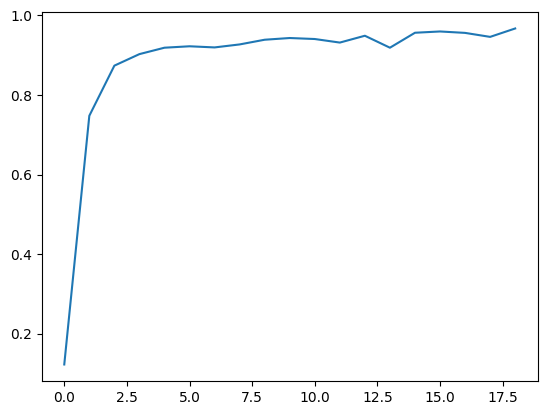

In [10]:
from matplotlib import pyplot as plt

model = db.load('model', model.identifier)

plt.plot(model.metric_values['my_valid/acc'])
plt.show()

Now that the model has been trained, we can use it to "watch" the data for incoming changes. 
This is set up with a simple predict "on" the database (without loading all the data client-side).

The `watch` toggle "activates" the model:

In [11]:
model.predict(X='img', db=db, select=collection.find(), watch=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1392.18it/s]


We can see that predictions are available in `_outputs.img.lenet5`:

In [19]:
db.execute(collection.find_one({'update': True}))['_outputs']

{'img': {'lenet5': 6}}

The models "activated" can be seen here:

In [16]:
db.show('watcher')

['lenet5/img']

We can verify that the model is activated, by inserting the rest of the data:

In [17]:
for r in data[-1000:]:
    r['update'] = True

db.execute(collection.insert_many(data[-1000:]))

INFO:root:found 0 uris
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1386.58it/s]


(<pymongo.results.InsertManyResult at 0x19063b820>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x1812fee90>, G=<networkx.classes.digraph.DiGraph object at 0x190caf810>))

You can see that the inserted data, are now also populated with predictions:

In [20]:
db.execute(collection.find_one({'update': True}))['_outputs']

{'img': {'lenet5': 6}}